In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller

# 1. Data Collection

In [2]:
def display_tickers(tickers):
    print("\nNifty 50 Company Ticker Symbols (Yahoo Finance Format):")
    print(*tickers, sep=", ")  

In [3]:
tickers_df = pd.read_csv("nifty50_tickers.csv")
tickers = tickers_df['Ticker'].tolist()
display_tickers(tickers)


Nifty 50 Company Ticker Symbols (Yahoo Finance Format):
ADANIENT.NS, ADANIPORTS.NS, APOLLOHOSP.NS, ASIANPAINT.NS, AXISBANK.NS, BAJAJ-AUTO.NS, BAJFINANCE.NS, BAJAJFINSV.NS, BEL.NS, BPCL.NS, BHARTIARTL.NS, BRITANNIA.NS, CIPLA.NS, COALINDIA.NS, DRREDDY.NS, EICHERMOT.NS, GRASIM.NS, HCLTECH.NS, HDFCBANK.NS, HDFCLIFE.NS, HEROMOTOCO.NS, HINDALCO.NS, HINDUNILVR.NS, ICICIBANK.NS, INDUSINDBK.NS, INFY.NS, ITC.NS, JSWSTEEL.NS, KOTAKBANK.NS, LT.NS, M&M.NS, MARUTI.NS, NESTLEIND.NS, NTPC.NS, ONGC.NS, POWERGRID.NS, RELIANCE.NS, SBILIFE.NS, SHRIRAMFIN.NS, SBIN.NS, SUNPHARMA.NS, TCS.NS, TATACONSUM.NS, TATAMOTORS.NS, TATASTEEL.NS, TECHM.NS, TITAN.NS, TRENT.NS, ULTRACEMCO.NS, WIPRO.NS


In [4]:

# Ask user for a company
user_input = input("\nPlease enter the name of the company you want to download data for: ").strip()

# Find the corresponding ticker (assumed tickers_df is already defined)
matched_ticker = None
for ticker in tickers_df['Ticker']:
    if ticker.split('.')[0].lower() == user_input.lower():
        matched_ticker = ticker
        break

# Download the data if ticker is found
if matched_ticker:
    folder = 'CSVfiles'  # Ensure the folder name is defined
    try:
        if not os.path.exists(folder):
            os.makedirs(folder)
        
        # Get yesterday's date
        yesterday = (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')
        
        # Download the stock data from 2017 to yesterday's date
        data = yf.download(matched_ticker, start='2017-01-01', end=yesterday)
        data.fillna(0, inplace=True)
        data
        
        # Save to CSV
        filename = os.path.join(folder, f"{matched_ticker}.csv")
        data.to_csv(filename)
        print(f"\nData for {matched_ticker} saved to {filename}")

    except Exception as e:
        print(f"An error occurred while downloading data for {matched_ticker}: {e}")

else:
    print("Company not found in Nifty 50 list.")


[*********************100%***********************]  1 of 1 completed


Data for INDUSINDBK.NS saved to CSVfiles\INDUSINDBK.NS.csv


In [5]:
yesterday = (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')

stock_data = yf.download(f'{user_input}.NS', start='2017-01-01', end=yesterday)
stock_data.fillna(0, inplace=True)
df = pd.DataFrame(stock_data)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,1109.949951,1114.650024,1082.349976,1087.449951,1032.594360,512397
2017-01-03,1088.000000,1113.900024,1082.050049,1100.599976,1045.080933,957645
2017-01-04,1094.000000,1107.400024,1093.000000,1100.150024,1044.653687,795470
2017-01-05,1107.000000,1129.849976,1104.050049,1127.550049,1070.671631,2264164
2017-01-06,1132.000000,1155.000000,1130.300049,1144.050049,1086.339233,1139667
...,...,...,...,...,...,...
2024-11-05,1063.699951,1092.400024,1062.000000,1090.099976,1090.099976,4840541
2024-11-06,1092.300049,1098.599976,1068.250000,1077.650024,1077.650024,7153974
2024-11-07,1086.000000,1086.000000,1051.000000,1056.800049,1056.800049,4901367


# 2. Data Preprocessing

<AxesSubplot: xlabel='Date'>

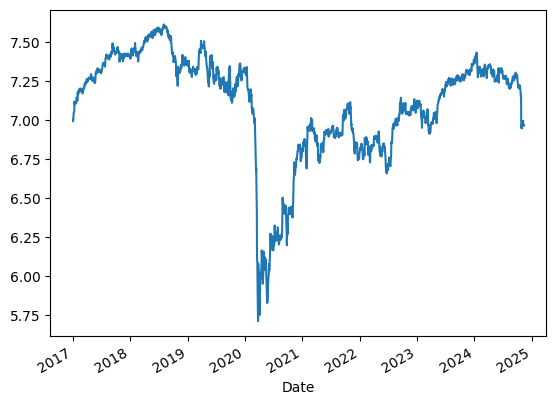

In [6]:
# This applies the natural logarithm (logarithm with base e) to the Close column of the DataFrame df.
# The reason for taking the logarithm of the closing prices is to stabilize the variance,
#  which can help in time series modeling (especially when working with non-stationary data). 
# Log transformations can reduce the effect of large fluctuations and make the data more stationary.


y = np.log(df["Close"])
y.plot()

In [7]:
y.asfreq("D")[:15] 

Date
2017-01-02    6.991591
2017-01-03    7.003611
2017-01-04    7.003202
2017-01-05    7.027802
2017-01-06    7.042330
2017-01-07         NaN
2017-01-08         NaN
2017-01-09    7.055529
2017-01-10    7.056779
2017-01-11    7.117854
2017-01-12    7.106524
2017-01-13    7.103034
2017-01-14         NaN
2017-01-15         NaN
2017-01-16    7.104555
Freq: D, Name: Close, dtype: float64

Let's impute the missing data by forward fill using asfreq method.

In [8]:
y.asfreq("D", method="ffill")[:15]   # used to forward fill missing values.

Date
2017-01-02    6.991591
2017-01-03    7.003611
2017-01-04    7.003202
2017-01-05    7.027802
2017-01-06    7.042330
2017-01-07    7.042330
2017-01-08    7.042330
2017-01-09    7.055529
2017-01-10    7.056779
2017-01-11    7.117854
2017-01-12    7.106524
2017-01-13    7.103034
2017-01-14    7.103034
2017-01-15    7.103034
2017-01-16    7.104555
Freq: D, Name: Close, dtype: float64

Formal of way of test for stationarity. Since the p-value of Augmented Dickey Fullter test is > 0.05,
we can say that there is not sufficient proof that the time series is stationary. 
Loosely speaking, it is non-stationary. We need further transformation to make data stationary.
Populary method for making data stationary will be to take "difference". 
Taking difference by lag one, we see the p-val for Dickey Fuller test is < 0.05. 
So we conclude, diff 1 will made the data stationary. 

In [9]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(prices):
    result=adfuller(prices)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

        
adfuller_test(df['Close'])

ADF Test Statistic : -1.5796895142368652
p-value : 0.49378758490662455
#Lags Used : 0
Number of Observations Used : 1941
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
result = adfuller(y.diff(periods=1).dropna())

In [11]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -13.236084
p-value: 0.000000


<AxesSubplot: xlabel='Date'>

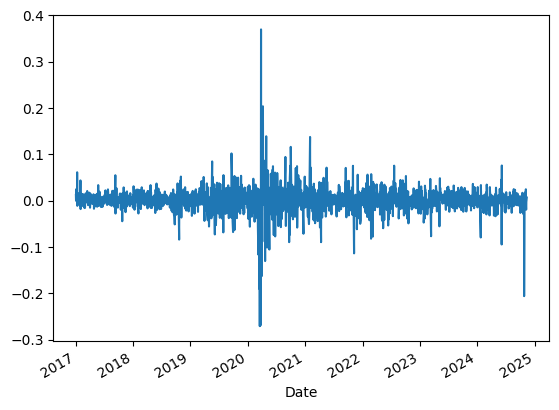

In [12]:
y.diff(periods=1).plot()

In [13]:
y

Date
2017-01-02    6.991591
2017-01-03    7.003611
2017-01-04    7.003202
2017-01-05    7.027802
2017-01-06    7.042330
                ...   
2024-11-05    6.994025
2024-11-06    6.982538
2024-11-07    6.963001
2024-11-08    6.960158
2024-11-11    6.966779
Name: Close, Length: 1942, dtype: float64

In [14]:
y = y.dropna()

# 3. Finding the p,d,q

Identification of an AR model is often best done with the PACF.

For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
Identification of an MA model is often best done with the ACF rather than the PACF. p,d,q

For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.
p AR model lags d differencing q MA lags

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


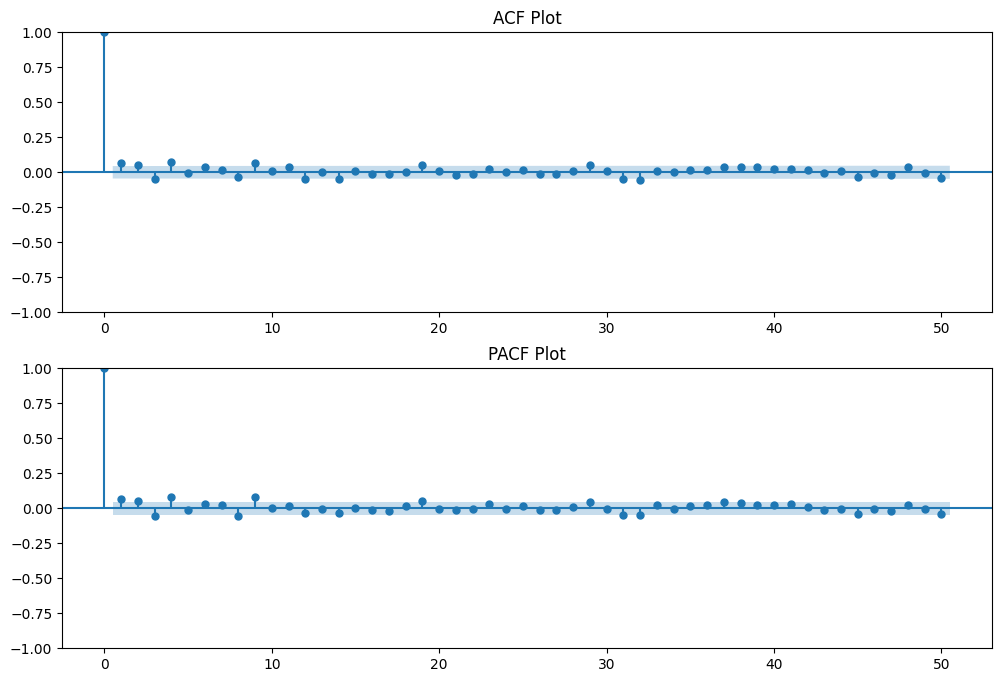

In [15]:
# Plot ACF and PACF for differenced data

plt.figure(figsize=(12, 8))

# ACF plot
plt.subplot(211)
plot_acf(y.diff(periods=1).dropna(), ax=plt.gca(), lags=50)
plt.title('ACF Plot')


# PACF plot
plt.subplot(212)
plot_pacf(y.diff(periods=1).dropna(), ax=plt.gca(), lags=50)
plt.title('PACF Plot')
plt.show()

c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


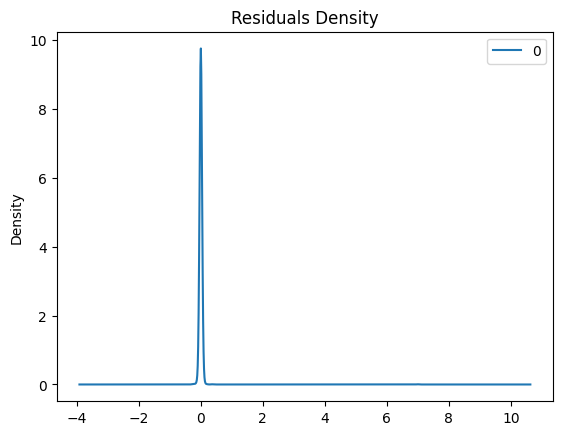

                 0
count  1942.000000
mean      0.003589
std       0.160940
min      -0.278506
25%      -0.010110
50%      -0.000117
75%       0.011535
max       6.991591


In [16]:
from statsmodels.tsa.arima.model import ARIMA


# fit model
# model = ARIMA(y, order=(5, 1, 0))  # p, d, q
model = ARIMA(y, order=(5, 1, 0))
model_fit = model.fit()

#print(model_fit.summary())

import pandas as pd
import matplotlib.pyplot as plt

# Residual density refers to the distribution of residuals from a statistical model. 
# Residuals are the differences between the observed values and the values predicted by the model.

# Purpose: By examining the residual density, you can assess whether residuals are normally distributed 
# and identify any patterns or anomalies that suggest problems with the model.

# plot residual erros
residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# residuals.plot(kind='kde')
# print(residuals.describe())

# Plot residuals density
residuals.plot(kind='kde')
plt.title('Residuals Density')
plt.show()

# Print residuals description
print(residuals.describe())


c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ronak\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


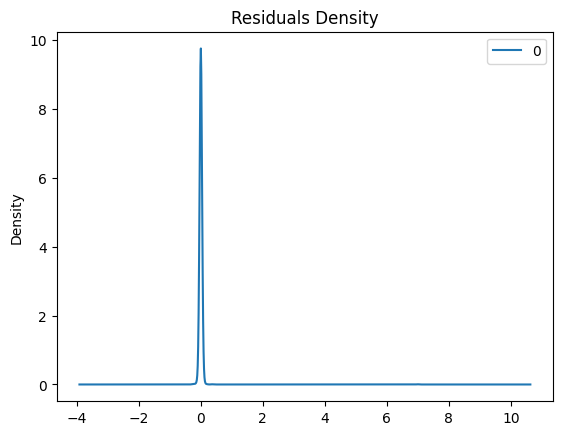

                 0
count  1942.000000
mean      0.003589
std       0.160940
min      -0.278506
25%      -0.010110
50%      -0.000117
75%       0.011535
max       6.991591


In [17]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y, order=(1, 1, 1))
model_fit = model.fit()

#print(model_fit.summary())

import pandas as pd
import matplotlib.pyplot as plt

# Plot residuals density
residuals.plot(kind='kde')
plt.title('Residuals Density')
plt.show()

# Print residuals description
print(residuals.describe())


In [18]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1942
Model:                 ARIMA(1, 1, 1)   Log Likelihood                4242.829
Date:                Wed, 13 Nov 2024   AIC                          -8479.657
Time:                        14:19:00   BIC                          -8462.944
Sample:                             0   HQIC                         -8473.511
                               - 1942                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1000      0.164      0.609      0.543      -0.222       0.422
ma.L1         -0.0371      0.169     -0.219      0.827      -0.369       0.295
sigma2         0.0007   5.62e-06    131.640      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             92411.99
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
model.endog

array([[6.99159074],
       [7.00361074],
       [7.00320184],
       ...,
       [6.9630008 ],
       [6.960158  ],
       [6.96677867]])

# 4 . Data Splitting and Model Fitting

Spliting the data
we split the normalized data into training and testing sets :

70% for training,
30% for testing.

predicted=6.677671, actual=6.693571
predicted=6.693986, actual=6.723832
predicted=6.727981, actual=6.714231
predicted=6.711747, actual=6.729286
predicted=6.729644, actual=6.758095
predicted=6.764794, actual=6.743588
predicted=6.740917, actual=6.755012
predicted=6.754763, actual=6.741760
predicted=6.744628, actual=6.708145
predicted=6.701827, actual=6.710401
predicted=6.711508, actual=6.703249
predicted=6.703907, actual=6.746471
predicted=6.747079, actual=6.766307
predicted=6.771183, actual=6.779126
predicted=6.777065, actual=6.854460
predicted=6.864587, actual=6.848483
predicted=6.851392, actual=6.869066
predicted=6.865870, actual=6.868599
predicted=6.876553, actual=6.887348
predicted=6.885996, actual=6.925300
predicted=6.931618, actual=6.950336
predicted=6.952689, actual=6.947120
predicted=6.946763, actual=6.972841
predicted=6.976480, actual=6.964419
predicted=6.966898, actual=6.956736
predicted=6.953143, actual=6.943412
predicted=6.944830, actual=6.956736
predicted=6.956906, actual=6

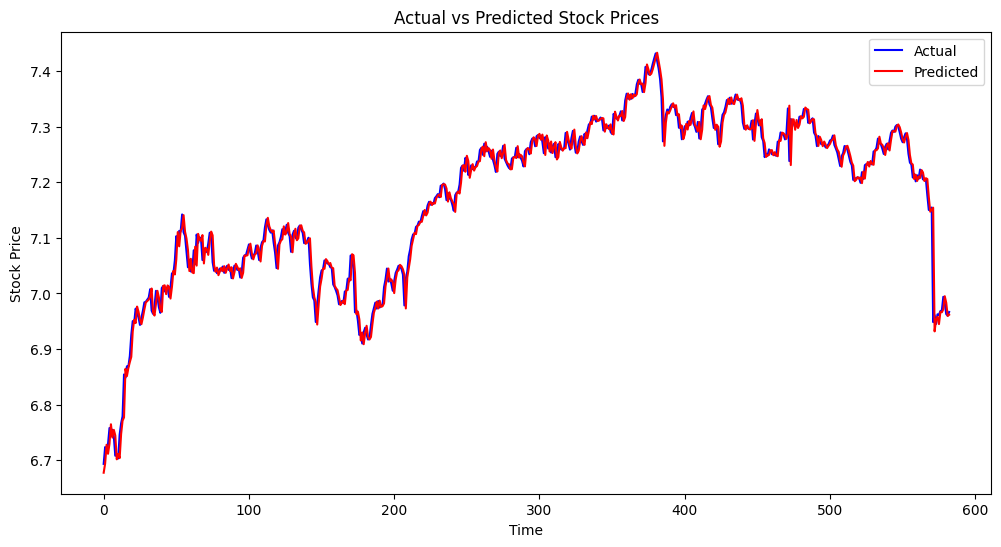

In [20]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Ignore specific warnings
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")

# Example data setup (ensure y is defined and contains your data)
x = y.values
train_size = int(len(x) * 0.7)
train, test = x[0:train_size], x[train_size:]

history = list(train)  # Use list() to ensure history is a list
predictions = []

# # Use test samples
num_predictions = len(test)
cnt = 0

for t in range(len(test)):
    if cnt == num_predictions:
        break
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()  # No disp argument
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'predicted={yhat:.6f}, actual={obs:.6f}')
    cnt += 1

# Ensure predictions and test have the same length
if len(predictions) != num_predictions:
    raise ValueError(f"Predictions length ({len(predictions)}) does not match expected number ({num_predictions})")

# Slice the test set to match the length of predictions
test_slice = test[:num_predictions]

# Calculate error
error = mean_squared_error(test_slice, predictions)
print(f'Test RMSE: {np.sqrt(error):.3f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_slice, label='Actual', color='blue')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [22]:
# Calculate metrics
mae = mean_absolute_error(test_slice, predictions)
mse = mean_squared_error(test_slice, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_slice - predictions) / test_slice)) * 100
r2 = r2_score(test_slice, predictions)

print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'Mean Squared Error (MSE): {mse:.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R²): {r2:.3f}')

Mean Absolute Error (MAE): 0.013
Mean Squared Error (MSE): 0.000
Root Mean Squared Error (RMSE): 0.019
Mean Absolute Percentage Error (MAPE): 0.18%
R-squared (R²): 0.983


In [23]:
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error
# import numpy as np
# import matplotlib.pyplot as plt

# x = y.values
# train_size = int(len(x) * 0.7)
# train, test = x[0:train_size], x[train_size:]
# history = [x for x in train]
# predictions = []

# for t in range(len(test)):
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit()  # No disp argument
#     output = model_fit.forecast(steps=1)
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test[t]
#     history.append(obs)
#     print('predicted=%f, actual=%f' % (yhat, obs))

# error = mean_squared_error(test, predictions)
# print('Test RMSE: %.3f' % np.sqrt(error))

# plt.plot(test, label='Actual')
# plt.plot(predictions, color='red', label='Predicted')
# plt.legend()
# plt.show()


# 5. Making the predictions 

In [24]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Assume y is your log-transformed time series data and already loaded
x_log = y.values

# Fit the ARIMA model on the log-transformed data
model = ARIMA(x_log, order=(5,1,0))  # p, d, q
model_fit = model.fit()

# Forecast the next value in the log-transformed scale
forecast_log = model_fit.forecast(steps=1) # next day
forecast_log_value = forecast_log[0]

# Reverse the logarithmic transformation to get the actual price
forecast_value = np.exp(forecast_log_value)

# Get tomorrow's date
today = datetime.now()
tomorrow = today + timedelta(days=1)
tomorrow_date_str = tomorrow.strftime('%Y-%m-%d')  # Format date as YYYY-MM-DD

print(f'The predicted stock price for {tomorrow_date_str} is: {forecast_value:.2f}')


The predicted stock price for 2024-11-14 is: 1061.11


                        Date  Forecasted Price
0 2024-11-14 14:29:21.016611       1061.114588
1 2024-11-15 14:29:21.016611       1060.119300
2 2024-11-16 14:29:21.016611       1059.645111
3 2024-11-17 14:29:21.016611       1060.156796
4 2024-11-18 14:29:21.016611       1060.168075
5 2024-11-19 14:29:21.016611       1060.137338
6 2024-11-20 14:29:21.016611       1060.077758
7 2024-11-21 14:29:21.016611       1060.119291
8 2024-11-22 14:29:21.016611       1060.115670
9 2024-11-23 14:29:21.016611       1060.118441


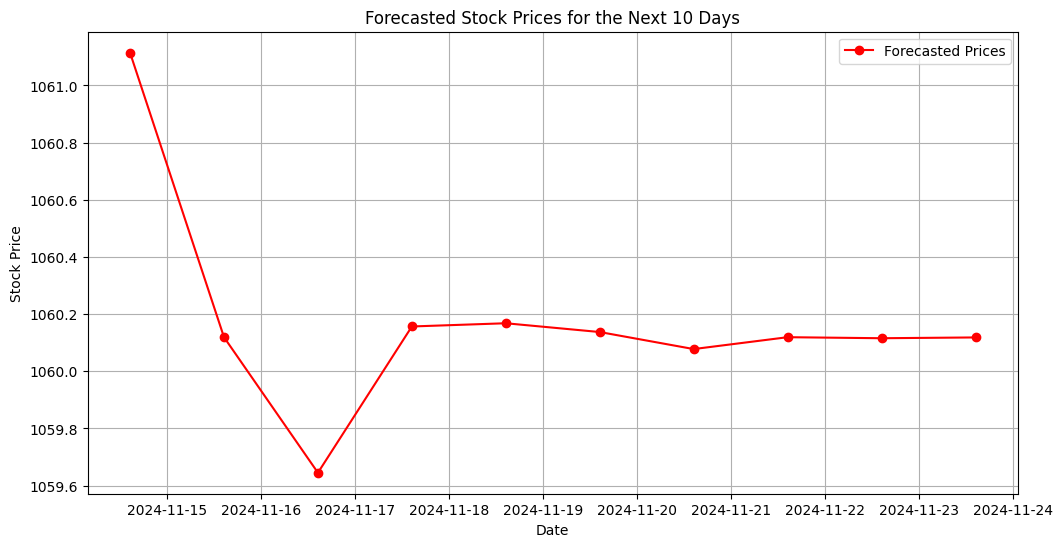

In [25]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume y is your log-transformed time series data and already loaded
x_log = y.values

# Fit the ARIMA model on the log-transformed data
model = ARIMA(x_log, order=(5,1,0))  # p, d, q
model_fit = model.fit()

# Forecast the next 10 days in the log-transformed scale
forecast_log = model_fit.forecast(steps=10)
forecast_log_values = forecast_log

# Reverse the logarithmic transformation to get the actual prices
forecast_values = np.exp(forecast_log_values)

# Generate dates for the next 10 days
last_date = pd.to_datetime('today')  # Adjust if you have a specific end date
dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=10, freq='D')

# Create a DataFrame to display results
forecast_df = pd.DataFrame({
    'Date': dates,
    'Forecasted Price': forecast_values
})

print(forecast_df)

# Optional: Plot the forecasted prices
plt.figure(figsize=(12, 6))
plt.plot(dates, forecast_values, marker='o', linestyle='-', color='red', label='Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Forecasted Stock Prices for the Next 10 Days')
plt.legend()
plt.grid()
plt.show()


In [26]:


# # Example data setup (ensure y is defined and contains your time series data)
# x = y.values  # y is your data series
# train_size = int(len(x) * 0.6)  # 60% for training
# validation_size = int(len(x) * 0.2)  # 20% for validation

# # Split the data into training, validation, and testing
# train = x[:train_size]
# validation = x[train_size:train_size + validation_size]
# test = x[train_size + validation_size:]

# history = list(train)  # Use list() to ensure history is a list
# validation_predictions = []
# test_predictions = []

# # 1. Validation predictions
# for t in range(len(validation)):
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit()
#     output = model_fit.forecast(steps=1)
#     yhat = output[0]
#     validation_predictions.append(yhat)
#     obs = validation[t]
#     history.append(obs)
#     print(f'Validation - predicted={yhat:.6f}, actual={obs:.6f}')

# # 2. Test predictions
# for t in range(len(test)):
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit()
#     output = model_fit.forecast(steps=1)
#     yhat = output[0]
#     test_predictions.append(yhat)
#     obs = test[t]
#     history.append(obs)
#     print(f'Test - predicted={yhat:.6f}, actual={obs:.6f}')

# # Calculate RMSE for validation and test sets
# validation_error = mean_squared_error(validation, validation_predictions)
# test_error = mean_squared_error(test, test_predictions)

# print(f'Validation RMSE: {np.sqrt(validation_error):.3f}')
# print(f'Test RMSE: {np.sqrt(test_error):.3f}')

# # Plot the results
# plt.figure(figsize=(14, 7))

# # Plot training data
# plt.plot(range(len(train)), train, label='Training Data', color='green')

# # Plot validation predictions and actual validation data
# plt.plot(range(len(train), len(train) + len(validation)), validation, label='Validation Data', color='blue')
# plt.plot(range(len(train), len(train) + len(validation)), validation_predictions, label='Validation Predictions', linestyle='--', color='orange')

# # Plot test predictions and actual test data
# plt.plot(range(len(train) + len(validation), len(x)), test, label='Test Data', color='blue')
# plt.plot(range(len(train) + len(validation), len(x)), test_predictions, label='Test Predictions', linestyle='--', color='red')

# plt.xlabel('Time')
# plt.ylabel('Stock Price')
# plt.title('Training, Validation, and Test Data vs Predictions')
# plt.legend()
# plt.show()


## 6. SARIMA

predicted=6.675749, actual=6.693571
predicted=6.700412, actual=6.723832
predicted=6.727209, actual=6.714231
predicted=6.710969, actual=6.729286
predicted=6.723548, actual=6.758095
predicted=6.759305, actual=6.743588
predicted=6.743145, actual=6.755012
predicted=6.757497, actual=6.741760
predicted=6.743309, actual=6.708145
predicted=6.705410, actual=6.710401
predicted=6.713515, actual=6.703249
predicted=6.702108, actual=6.746471
predicted=6.744365, actual=6.766307
predicted=6.774817, actual=6.779126
predicted=6.777168, actual=6.854460
predicted=6.861656, actual=6.848483
predicted=6.844567, actual=6.869066
predicted=6.861139, actual=6.868599
predicted=6.877330, actual=6.887348
predicted=6.891035, actual=6.925300
Test RMSE: 0.027


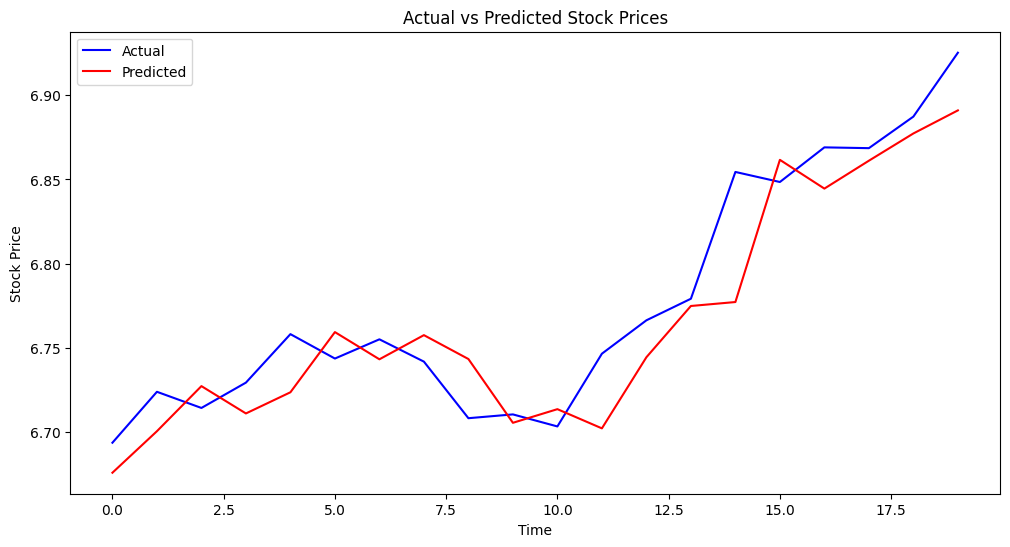

In [26]:
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")

x = y.values
train_size = int(len(x) * 0.7)
train, test = x[0:train_size], x[train_size:]

history = list(train)  # Use list() to ensure history is a list
predictions = []

# Define SARIMA parameters
# Adjust the (p, d, q) and (P, D, Q, s) parameters based on your data
seasonal_period = 12  # Example: monthly data with yearly seasonality
num_predictions = 20
cnt = 0

for t in range(len(test)):
    if cnt == num_predictions:
        break
    model = SARIMAX(history, order=(5,1,0), seasonal_order=(1,1,1,seasonal_period))
    model_fit = model.fit(disp=False)  # No disp argument
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'predicted={yhat:.6f}, actual={obs:.6f}')
    cnt += 1

# Ensure predictions and test have the same length
if len(predictions) != num_predictions:
    raise ValueError(f"Predictions length ({len(predictions)}) does not match expected number ({num_predictions})")

# Slice the test set to match the length of predictions
test_slice = test[:num_predictions]

# Calculate error
error = mean_squared_error(test_slice, predictions)
print(f'Test RMSE: {np.sqrt(error):.3f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_slice, label='Actual', color='blue')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

In [28]:
# Calculate metrics
mae = mean_absolute_error(test_slice, predictions)
mse = mean_squared_error(test_slice, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_slice - predictions) / test_slice)) * 100
r2 = r2_score(test_slice, predictions)

print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'Mean Squared Error (MSE): {mse:.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R²): {r2:.3f}')

Mean Absolute Error (MAE): 0.022
Mean Squared Error (MSE): 0.001
Root Mean Squared Error (RMSE): 0.027
Mean Absolute Percentage Error (MAPE): 0.32%
R-squared (R²): 0.844


In [29]:
model = SARIMAX(x_log, order=(5,1,0), seasonal_order=(1,1,1,12))  # Example parameters
model_fit = model.fit(disp=False)

# Forecast the next value in the log-transformed scale
forecast_log = model_fit.forecast(steps=1) # next day
forecast_log_value = forecast_log[0]

# Reverse the logarithmic transformation to get the actual price
forecast_value = np.exp(forecast_log_value)

# Get tomorrow's date
today = datetime.now()
tomorrow = today + timedelta(days=1)
tomorrow_date_str = tomorrow.strftime('%Y-%m-%d')  # Format date as YYYY-MM-DD

print(f'The predicted stock price for {tomorrow_date_str} is: {forecast_value:.2f}')

The predicted stock price for 2024-11-14 is: 1072.18


         Date  Forecasted Price
0  2024-11-14       1072.177225
1  2024-11-15       1070.793112
2  2024-11-16       1071.453368
3  2024-11-17       1072.285451
4  2024-11-18       1070.624128
5  2024-11-19       1069.024754
6  2024-11-20       1072.374399
7  2024-11-21       1072.898743
8  2024-11-22       1071.707447
9  2024-11-23       1069.730355


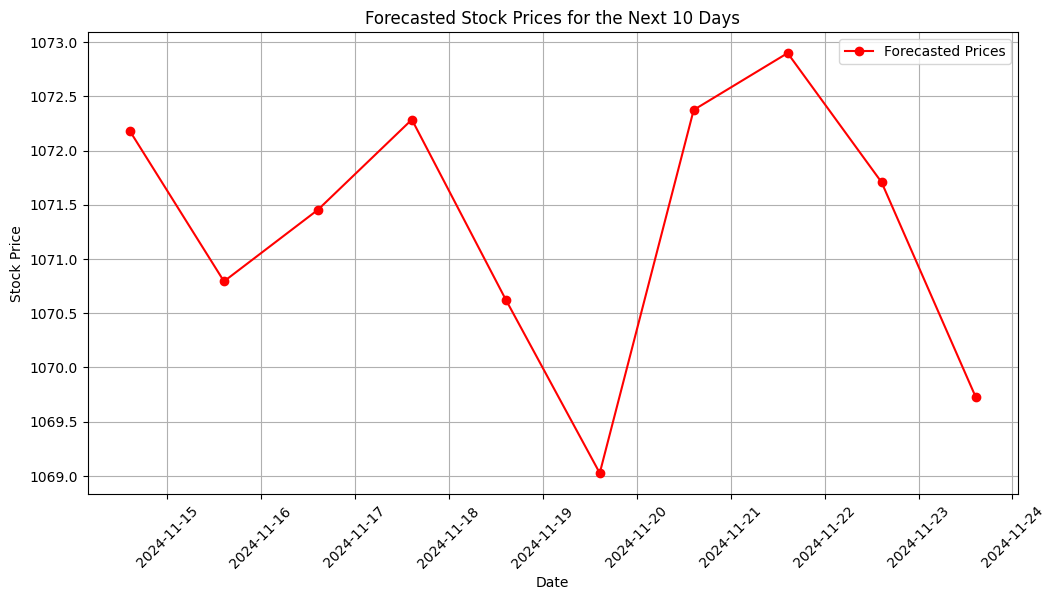

In [30]:
# Assume y is your log-transformed time series data and already loaded
x_log = y.values

# Define the SARIMA model
# Example parameters; adjust these based on your data and seasonal period
model = SARIMAX(x_log, order=(5,1,0), seasonal_order=(1,1,1,12))  # Adjust parameters as needed
model_fit = model.fit(disp=False)

# Forecast the next 10 days in the log-transformed scale
forecast_log = model_fit.forecast(steps=10)
forecast_log_values = forecast_log

# Reverse the logarithmic transformation to get the actual prices
forecast_values = np.exp(forecast_log_values)

# Generate dates for the next 10 days
today = datetime.now()
dates = [today + timedelta(days=i+1) for i in range(10)] 
dates_str = [date.strftime('%Y-%m-%d') for date in dates]

# Create a DataFrame to display results
forecast_df = pd.DataFrame({
    'Date': dates_str,
    'Forecasted Price': forecast_values
})

print(forecast_df)

# Optional: Plot the forecasted prices
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dates, forecast_values, marker='o', linestyle='-', color='red', label='Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Forecasted Stock Prices for the Next 10 Days')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


In [31]:
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA

# # Assume y is your log-transformed time series data and already loaded
# x_log = y.values
# train_size = int(len(x_log) * 0.7)
# train, test = x_log[0:train_size], x_log[train_size:]
# test_actual = np.exp(test)  # Convert test data back to original scale
# history = [x for x in train]
# predictions = []

# # Forecasting the test period
# for t in range(len(test)):
#     model = ARIMA(history, order=(5,1,0))  # p, d, q
#     model_fit = model.fit()
#     output = model_fit.forecast(steps=1)
#     yhat_log = output[0]
#     yhat = np.exp(yhat_log)  # Convert forecasted log value back to original scale
#     predictions.append(yhat)
#     obs = np.exp(test[t])  # Ensure actual test values are in original scale
#     history.append(test[t])
#     # print('predicted=%f, actual=%f' % (yhat, obs))

# # Convert predictions to a numpy array for easy plotting
# predictions = np.array(predictions)

# # Plot actual vs predicted prices
# plt.figure(figsize=(12, 6))
# plt.plot(test_actual, label='Actual Prices', color='blue')
# plt.plot(predictions, color='red', label='Predicted Prices')
# plt.xlabel('Time')
# plt.ylabel('Stock Price')
# plt.title('Actual vs Predicted Stock Prices')
# plt.legend()
# plt.show()
